---
title: "📝 ChatGPT Prompt Engineering"
author: "Bhargav Kowshik"
date: "2023-08-18"
categories:
    - prompt engineering
    - mooc
    - deeplearning.ai
title-block-banner: true
execute: 
  enabled: false
  echo: false
  freeze: true  # Don't re-render during project render.
format:
  html:
    toc: true
    toc-depth: 2
---

![](../../../static/images/chatgpt-prompt-engineering/wordcloud.png)

In [38]:
# Hide warnings from Jupyter notebook outputs.
import warnings
warnings.filterwarnings('ignore')

# Install the required dependencies to run the notebook.
!pip install --upgrade --quiet openai wordcloud

In [25]:
import os
from getpass import getpass

%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt

import openai
from wordcloud import WordCloud

In [3]:
#| output: false
#| echo: false
if os.getenv('OPENAI_API_KEY') is None:
    os.environ['OPENAI_API_KEY'] = getpass('Paste your OpenAI key:\n')
openai.api_key = os.getenv('OPENAI_API_KEY')

Course: [ChatGPT Prompt Engineering for Developer . DeepLearning.AI](https://www.deeplearning.ai/short-courses/chatgpt-prompt-engineering-for-developers/) by Isa Fulford and Andrew Ng.

---

# 1. Introduction

> The power of Large Language Models (LLMs) as a developer tool, using API calls to LLMs to quickly build software applications is still very **under-appreciated**.

There are 2 types of Large Language Models (LLMs):

1. Base LLMs.
2. Instruction Tuned LLMs.

Given an input prompt, base LLMs are trained to predict the next word. Ex: [meta-llama/Llama-2-7b-hf](https://huggingface.co/meta-llama/Llama-2-7b-hf).

Instruction tuned LLMs are built on top of base LLMs to follow instructions using techniques of supervised fine-tuning (SFT) and reinforcement learning using human feedback (RLHF). Ex: [meta-llama/Llama-2-7b-chat-hf](https://huggingface.co/meta-llama/Llama-2-7b-chat-hf) and [gpt-3.5-turbo from OpenAI](https://platform.openai.com/docs/guides/gpt).

Below is an example to generate text from a prompt using OpenAI `gpt-turbo-3.5` model.

In [19]:
#| echo: true
system_prompt = 'You are a helpful assistant.'
user_prompt = 'Large Language Models (LLMs) are'

messages = [
    {'role': 'system', 'content': system_prompt},
    {'role': 'user', 'content': user_prompt}
]
response = openai.ChatCompletion.create(
    model='gpt-3.5-turbo',
    messages=messages,
    max_tokens=25
)
print(response)

{
  "id": "chatcmpl-7orEa0AuwrwkKPWGWsBhIO5n0d5Jx",
  "object": "chat.completion",
  "created": 1692355388,
  "model": "gpt-3.5-turbo-0613",
  "choices": [
    {
      "index": 0,
      "message": {
        "role": "assistant",
        "content": "advanced natural language processing models that are capable of generating human-like text based on a given prompt or input. These models are trained"
      },
      "finish_reason": "length"
    }
  ],
  "usage": {
    "prompt_tokens": 25,
    "completion_tokens": 25,
    "total_tokens": 50
  }
}


# 2. Guidelines for prompting

Important principles for effective prompting are:

1. Write clear and specific instructions. ✍️
2. When necessary, give the model time to think. 🤔


Tactics for writing clear and specific instructions are:

1. Longer prompts provide more clarity and context to the model.
2. Delimiters clearly indicate distinct parts in the input. Ex: Triple back-ticks.
3. Asking for structured outputs makes consuming them easier downstream. Ex: HTML, JSON.
4. Check whether the conditions/assumptions required to do the task are satisfied.
5. Give examples before asking the model to perform the task.


Tactics to give the model time to think are:

1. Explicitly specify the steps required to complete the task.
2. Instruct the model to work out it’s own solution first.

Below is an example incorporating some of these tactics for effective prompting.

In [5]:
#| echo: true
menu = """
Masala Dosa ₹100
Idli ₹30
Vada ₹40
Khara Bath ₹30
Kesari Bath ₹50
Coffee ₹15
Tea ₹15
Milk ₹10
"""
system_prompt = f"""
You are order bot, an automated service to collect and process orders at a South Indian restaurant.
Return the order as a JSON with keys customer_name, ordered_items as an array with name and price, tax and the final_amount.
The final amount should add up the to sum of the individual item amounts and the tax of ₹8.
Add a property called ai_generated and set it's value to true.

The restaurant menu is between triple back-ticks.
When an item is not on the menu, record it with an additional attribute called unavailable with value true and set price to zero.
```{menu}```
"""

user_prompt = """
Aneesh would like one Dosa, some fries, and a strong filter coffee.
"""

messages = [
    {'role': 'system', 'content': system_prompt},
    {'role': 'user', 'content': user_prompt},
]
response = openai.ChatCompletion.create(
    model='gpt-3.5-turbo',
    messages=messages,
    temperature=0,
)
print(response['choices'][0]['message']['content'])

{
  "customer_name": "Aneesh",
  "ordered_items": [
    {
      "name": "Masala Dosa",
      "price": 100
    },
    {
      "name": "Fries",
      "price": 0,
      "unavailable": true
    },
    {
      "name": "Coffee",
      "price": 15
    }
  ],
  "tax": 8,
  "final_amount": 123,
  "ai_generated": true
}


## 2.1 Iterative prompt development

Key to becoming an effective prompt engineer is to have a good process to develop effective prompts:

1. Try something, the first prompt for what you want to do.
2. Analyze where the results does not give what you want.
3. Clarify the instructions; giving more time for the model to think.
    - Zero shot learning when training examples are not given.
    - Few shot learning when some training examples are given as context.
4. Refine prompts with a batch of inputs instead of just one.

# 3. LLM use-cases

1. Summarization: Convert large volumes of text into smaller yet relavant summaries.
2. Inferring: Perform analysis on text like identifying sentiment, extracting order details, labelling with topics.
3. Transforming: Turn text from one format to another for translation, spelling correction, modifying tone.
4. Expanding: Given some text, generate an even larger form of text.

In [6]:
#| echo: true
#| code-fold: true
#| code-summary: "NOTE: Click here to view the reviews dataset used in the examples below."

# Source: https://goo.gl/maps/vc8ohkr3q6EVwEko6
reviews = """
Jaishri Shankar
4 days ago
I have been attending sparsh yoga classes for the past 1 year and it has been a  rejuvenating learning experience physically and mentally. All credits to Aparna for this wonderful experience whose expertise creates an atmosphere of calmness and a path to self-discovery.
Thanks sparsh yoga for this blissful journey

Ramesh Kanuri
2 weeks ago
Sparsh Yoga Institute is a very good place to learn and practice Yoga. Sarangi Madam is highly knowledgeable, experienced and supportive. I saw a good amount of difference within 3 months of my journey here. Overall, it had an excellent vibe and a lot of positivity and was the best place for the practice.

Bhargav Kowshik
2 weeks ago
Yoga classes at Sparsh Yoga with Suraksha mam has become an essential part of my daily routine. It has positively transformed my physical, mental, and emotional well-being. The quality of my practice has seen a remarkable change thanks to timely and clear corrections from Suraksha mam; things like how one enters and exits from asanas, being conscious about breathing, stretching gently beyond one's limits, and relavant theory behind the practices. Mam makes sure there is healthy variety in our practices; Reverse Surya Namaskara, Pair Yoga, Wall Yoga, Meditation, etc. All this make me eagerly attend Yoga classes at the center everyday. Thank you very much Suraksha mam and Sparsh Yoga.

Bidyarani Mainaly
3 months ago
Really good place to learn yoga and calm your mind. Reasonable price and great quality of training. Special shout out to Suraksha, she is an excellent yoga instructor with correct knowledge and skills. I was able to increase my weight because of her guidance. I'm able to focus on my work and studies because of yoga practice.

KUSHAL M
3 days ago
One of the best yoga center i have ever seen,I am doing yoga from past 3 months, i have increased my weight And I'm able to focus on my studies because of yoga practices.
Thank you Suraksha mam and Sparsh Yoga.

Healy Mehta
4 months ago
Perfect for beginners who want to learn about the yoga practice. Her attention to detail during our healing yoga session is unmatched. I felt a strong sense of calm, and every moment throughout my session was met with peace and tranquility. It is a great experience!!

Niharika Ramakrishna
a week ago
Started my yoga journey with sparsh yoga since may and it's undoubtedly one of the best decisions made , I' can see the changes for myself mentally and physically i struggled putting on weight now I can easily eat good amount of food and balance my weight I've been attending morning 10 am batch with aparna mam she's been an amazing mentor she constantly gives attention to everybody and corrects their postures and motivates us

Arpitha B
2 weeks ago
I have been going to sparsh yoga from 6months,in the evening batch ,my yoga instructor is suraksha mam,she teaches very well and gives one on one attention.Suraksha mam also explains the benefits of the asanas which is very essential to understand for better results.I enjoy coming to the evening batch and also hope in learning
advanced asanas soon.Thanks suraksha mam for your support and also the entire team of sparsh.

Roopa Muthraju
a week ago
This is the place where you can keep yourself fit and healthy ,Aparna is also very friendly teacher  and I got a lot of benefits from Sparsh Yoga Center. Thank you

sowmya das
a week ago
Very friendly teachers they give advices based on the concern we have, good environment to learn yoga

Kavya Madusudan
6 months ago
It's wonderful to learn yoga from Saranga Ma'am.I am happy to be a part of Sparsha yoga centre. Around two years of yoga learning under Saranga Ma'am has helped me in loosing weight, reduced Thyroid issues and lots of positive energy.Thankyou so much Saranga Ma'am.

saraswathy cs
4 months ago
I have been taking personal yoga sessions from Ms. Saranga since 2019. I have seen amazing results in her training. Thank you for the great job.

RAM Mehta
Saranga Maam Best trainer to help you achieve your goal and make you feel better about your self. Helped me alot in my postpartum weight and help in movement

Shwetha Suhas
6 months ago
It's been 2 years, happy to say that i m  one of the memeber of Sparsh yoga. I was suffering from asthma from childhood, after practicing yoga it helped me a lot to come out of this,  it's reduced now and i feel much better. Being a runner,  I must say  yoga gives strength and stamina. It was wonderful experience to do 108 Suryanamaskara on the auspicious day of  Ratha sapthami.  Thank u so much Saranga mam for the opportunity  and for being our Guru.

sushma vimmidi
7 months ago
Sparsh yoga is one of the best place to learn yoga for all age groups and body type. I joined the class about 2 months back and the amount of stamina I build is simply amazing. I have hypertion due to hereditary, in just less than 10days of yoga practice my BP is under control. A special thanks to the trainer Ms Aparna, she knows exactly what each one of us need and our weak points how we can overcome and go beyond. Thanks Sparsh family for running such an institution which is benefiting a lot of us all over the world. Namaste 🙏

Aditya Bhargava
2 weeks ago
It is the best Yoga center in South Bangalore. Instructors are great especially Suraksha.

Prathibha Jakkali
6 months ago
Hi, I am Prathibha where I am  taking yoga class  from saranga ma'am from last  1 year. Under her guidelines now I have balanced my life where I was having knee issues where i was not able to walk prooerly. After doing all the yoga for knee exercises,i am fit and fine now. I am able to walk properly. Thanks to saranga ma'am

Gayathri Rakesh
7 months ago
I have been doing yoga at sparsh yoga centre from 9 months .10 o'clock batch and my yoga guru is Aparna she is such a amazing Guru gives individual attention , I had PCOD problem I have been maintaining the same weight now and it's such a wonderful feeling after yoga with aparna . I am  feeling so good about myself everyday  now  , I would like to thank sparsh yoga center. Aparna i would love to be fit and fine with ur instructions and help  forever ♾️ thank you so much.

Gajendrachar m M
11 months ago
I Love this Yoga center 💛 Sarangi Mam is excellent in teaching Yoga and her experience level is truly awesome!!  I have been attending the classes here for almost 3 months now and the overall experiences are amazing!! Highly recommend this place to learn Yoga and this centre can be life changing and a wonderful experience!! …

Girish Vemulkar
a year ago
I was motivated by my wife to join yoga. It has been more than 6 months now and it's changed my life completely. At Sparsh , specially Saranga ma'am, focuses on everybody and every aspect of your needs and progress. Thanks to her I have lost almost 5kgs and counting. And the quality of my mental health and overall health has improved a lot. She has a great skill set to cater to individual needs. I would highly recommend this institute to everyone.
"""

## 3.1 Summarization

In [7]:
#| echo: true
system_prompt = 'You are a helpful professional assistant.'
user_prompt = f"""
Reviews about a Yoga center are between triple backticks.
First proofread and anonymize the reviews taking away names of reviewers as well as the teachers at the center.
Next, summarize it as an 3 item ordered list, each not more than 25 words to highlight the topics brought up in the reviews.

```{reviews}```
"""

response = openai.ChatCompletion.create(
    model='gpt-3.5-turbo',
    messages=[{'role': 'system', 'content': system_prompt}, {'role': 'user', 'content': user_prompt}],
    temperature=0.7,
)
print(response['choices'][0]['message']['content'])

Summary:

1. Rejuvenating Experience: The center creates a calm atmosphere and offers expert instruction, leading to physical and mental rejuvenation.
2. Knowledgeable and Supportive Teachers: The instructors are highly knowledgeable, experienced, and provide individual attention, resulting in noticeable improvements in a short time.
3. Positive Transformation: Students experience positive changes in their physical, mental, and emotional well-being, including weight management, increased focus, and improved overall health.


## 3.2 Information extraction

In [10]:
#| echo: true
system_prompt = 'You are a helpful professional assistant.'
user_prompt = f"""
Reviews about a Yoga center are between triple backticks.
Proofread the reviews and extract the names of teachers at the Yoga center in ascending order.

```{reviews}```
"""

response = openai.ChatCompletion.create(
    model='gpt-3.5-turbo',
    messages=[{'role': 'system', 'content': system_prompt}, {'role': 'user', 'content': user_prompt}],
)
print(response['choices'][0]['message']['content'])

The names of teachers at the Yoga center in ascending order are:
1. Aparna
2. Sarangi
3. Suraksha


## 3.3 Tagging

In [14]:
#| echo: true
system_prompt = 'You are a helpful professional assistant.'
user_prompt = f"""
Reviews about a Yoga center are between triple backticks.
Proofread the reviews and identify the top 10 qualities of the Yoga center along with the count of reviews that mention that quality.
Sort the list in descending order of count of reviews.

```{reviews}```
"""

response = openai.ChatCompletion.create(
    model='gpt-3.5-turbo',
    messages=[{'role': 'system', 'content': system_prompt}, {'role': 'user', 'content': user_prompt}],
)
print(response['choices'][0]['message']['content'])

Top 10 Qualities of the Yoga center:

1. Experienced and Knowledgeable Instructors (Count: 9)
2. Personalized Attention and Corrective Guidance (Count: 8)
3. Positive Environment and Vibe (Count: 7)
4. Transformational and Life-changing Experience (Count: 6)
5. Health Benefits and Weight Management (Count: 5)
6. Focus on Breathing and Mindfulness (Count: 4)
7. Variety in Yoga Practices and Asanas (Count: 3)
8. Friendly and Supportive Teachers (Count: 2)
9. Reasonable Price and Value for Money (Count: 1)
10. Improvement in Mental and Emotional Well-being (Count: 1)

The list is sorted in descending order of the count of reviews mentioning each quality.


## 3.4 Expanding

In [18]:
#| echo: true
system_prompt = 'You are a helpful professional assistant.'
user_prompt = f"""
Reviews about a Yoga center are between triple backticks.
Proofread and anonymize the reviews taking away names of reviewers as well as the teachers at the center.
Use that to write a Haiku.
```{reviews}```
"""

response = openai.ChatCompletion.create(
    model='gpt-3.5-turbo',
    messages=[{'role': 'system', 'content': system_prompt}, {'role': 'user', 'content': user_prompt}],
)
print(response['choices'][0]['message']['content'])

Rejuvenating bliss,
Expert guidance guides the path,
Peace and strength within.


::: {.content-hidden}
## 3.5 Word cloud
:::

(-0.5, 2499.5, 1599.5, -0.5)

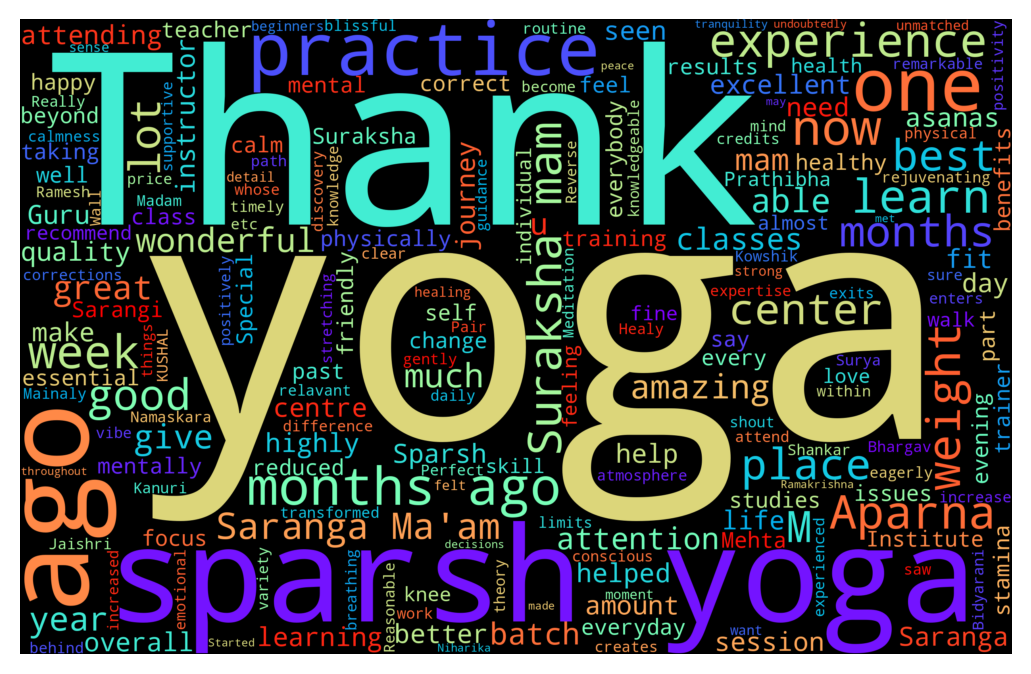

In [37]:
#| output: false
#| echo: false
wordcloud = WordCloud(width=2500, height=1600, colormap='rainbow').generate(reviews)
wordcloud.to_file('../../../static/images/chatgpt-prompt-engineering/wordcloud.png');
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")